# **03_Modelling and Evaluating**

## Objectives

**Provide ability to answer business requirement 2**

* The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.


## Inputs

* inputs/dataset/cherry_leaves_dataset/cherry-leaves/test
* inputs/dataset/cherry_leaves_dataset/cherry-leaves/train
* inputs/dataset/cherry_leaves_dataset/cherry-leaves/validation
* image shape embeddings


## Outputs

* create ability to answer for Business Requirements 2
* create plot for image distribution in train, validation, and test set
* Image augmentation
* Class indices to change prediction inference in labels
* Machine learning model creation and training
* Save the model
* Learning curve plot for model performance
* Model evaluation on pickle file
* Prediction on the random image file



---

# Set Data Directory

### Import libraries and model packages

In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping


2025-03-29 08:32:04.018443: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-29 08:32:04.050229: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Set working directory

Change the working directory from its current folder to its parent folder
> access the current directory with ```os.getcwd()```

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-mildew-detection/jupyter_notebooks'

Make the parent of the current directory the new current directory
> ```os.path.dirname()``` gets the parent directory; ```os.chir()``` defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-mildew-detection'

### Set input directories

Set train, validation an test paths.

In [5]:
my_data_dir = 'inputs/dataset/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set label names

In [7]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


### Set image shape

In [8]:
# Import saved image shape embedding
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Count numbers of images in train, test and validation data and display them in a chart

#### Bar Chart

First we count the number of images in each label, show and save them in a bar chart.


* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




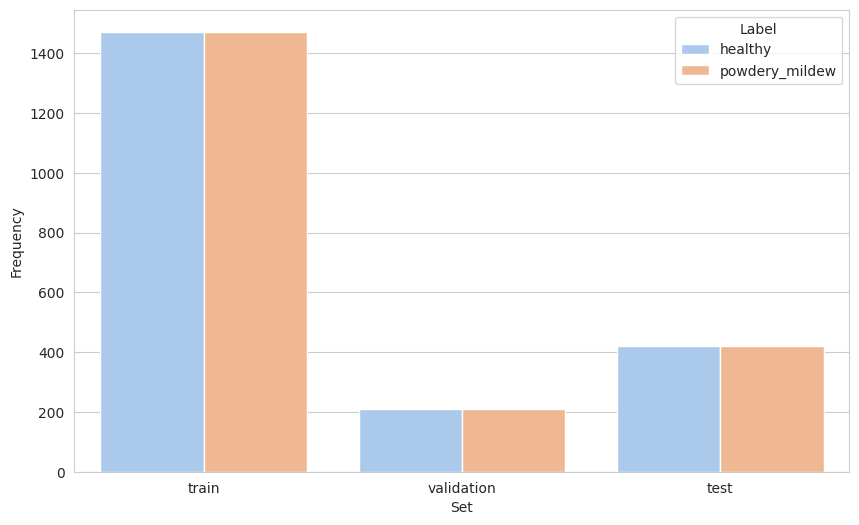

In [9]:
# code for Data Visualization and its functions were adapted and taken from Walkthrough Project 01 Malaria Detector 

# Create an empty dictionary
data_dict = {
    'Set': [],
    'Label': [],
    'Frequency': []
}

# Define the number of rows you want to create
image_folders = ['train', 'validation', 'test']

# Loop to dynamically create and append rows to the dictionary
for image_folder in image_folders:
    for label in labels:
        row = {
            'Set': image_folder,
            'Label': label,
            'Frequency': int(len(os.listdir(my_data_dir + '/' + image_folder + '/' + label)))  
        }
        for key, value in row.items():
            data_dict[key].append(value)
        print(
            f"* {image_folder} - {label}: {len(os.listdir(my_data_dir+'/'+ image_folder + '/' + label))} images")

# Convert the dictionary to a DataFrame
df_freq = pd.DataFrame(data_dict)

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label', palette='pastel')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

#### Pie Chart

Again we count the number of images in each label to check if the next part of code uses the correct data, show and save them in a pie chart.

Unlike the previous bar chart this pie chart only shows the total image distributioj between train-, validation- and test sets.

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images


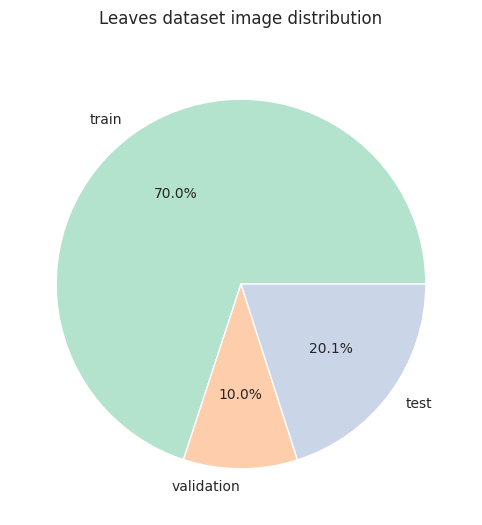

In [10]:
# looked up other students projects to be able to subdivide each set
# into healthy and mildew infected parts, nothing so far & everything else I tried was buggy

image_folders = ['train', 'validation', 'test']
data_list=[]
for image_folder in image_folders:
    for label in labels:
        n=int(len(os.listdir(my_data_dir + '/' + image_folder + '/' + label)))
        n+=n
        print(
            f"* {image_folder} - {label}: {len(os.listdir(my_data_dir+'/'+ image_folder + '/' + label))} images")
    data_list.append(n)


px = 1/plt.rcParams['figure.dpi'] 
plt.subplots(figsize=(12,6))
plt.pie(data_list, labels = image_folders, colors = plt.cm.Pastel2.colors, autopct='%.1f%%')
plt.title(f'Leaves dataset image distribution\n')
plt.savefig(f'{file_path}/image_distribution_piechart.png', bbox_inches='tight', dpi=150)
plt.show()

---

## Image augmentation

Since we require more data for our deep learning models, we inrease the number of randomized images. That is why we use image augmentation.

### Initialize ImageDataGenerator

We use the ```ImageDataGenerator ``` funtion whih generates batches of image data.

These images are generated from our already existing data, by:
* rotating imagges by 20 degree
* shifting the width and height of the images by a 0.1 ratio
* shearing the image by 0.1
* zooming into the image by 10%
* flipping the image
* fillig broken pixels

This is saved in the variable ```augmented_image_data ```.

In [11]:
# code for Data Visualization and its functions were adapted and taken from Walkthrough Project 01 Malaria Detector 
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Augment training image dataset

We set the batch size and augment our training data set.

We get data directly from the training dataset through the ```flow_from_directory ``` and transform every single data piece/image. Each image is transformed with the ```image_shape``` variable, the RGB colour mode, the batch size, which is set to 20, the binary class mode, whih is used since we have two labels, hence two classes and then shuffled randomly

In [12]:
# code for Data Visualization and its functions were adapted and taken from Walkthrough Project 01 Malaria Detector 
batch_size = 20  # this sets the batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

We do the same with the validation and test data set

### Augment validation image dataset

In [13]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment test image dataset

In [14]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

The class indices are the same for all datasets. ```0``` for healthy leaes & ```1``` for mildew infeted leaves.

### Plot augmented training image

Now we plot the augmented images. We startg with plotting the augmented training images.


(20, 256, 256, 3)


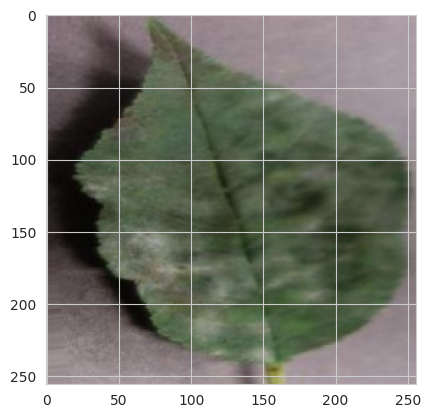

(20, 256, 256, 3)


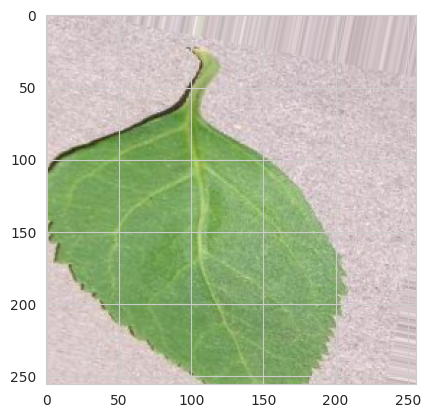

(20, 256, 256, 3)


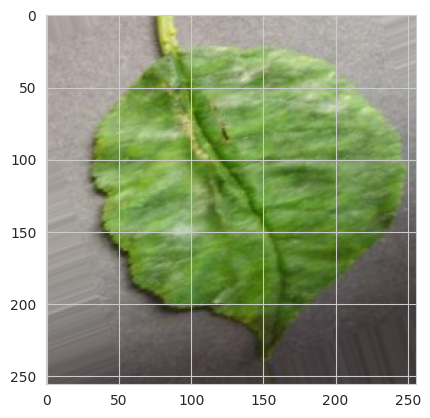

(20, 256, 256, 3)


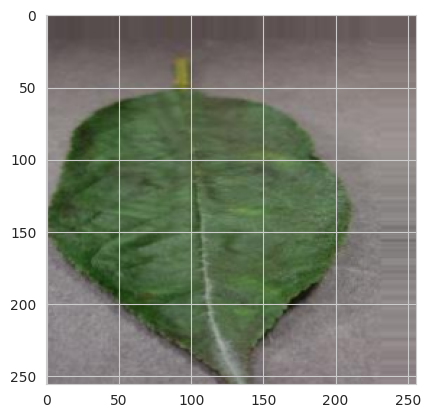

In [15]:
for _ in range(4):
    img, label = next(train_set)
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

As expeted the images look transformed compared to the image montage from our previous notebook. This meand our transformation and hence augmentation was succesfull.

We do the same for the validation and test datasets.

### Plot augmented validation images

(20, 256, 256, 3)


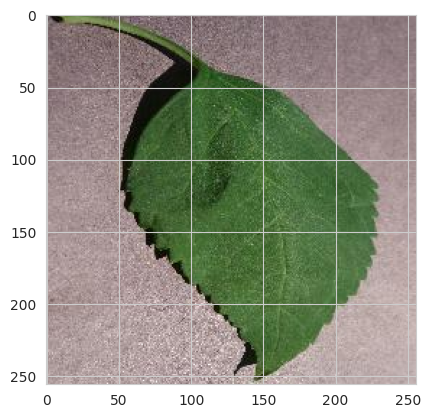

(20, 256, 256, 3)


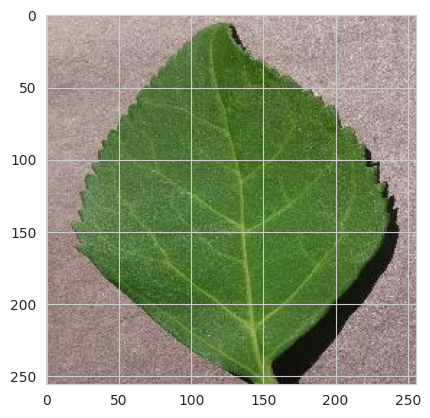

(20, 256, 256, 3)


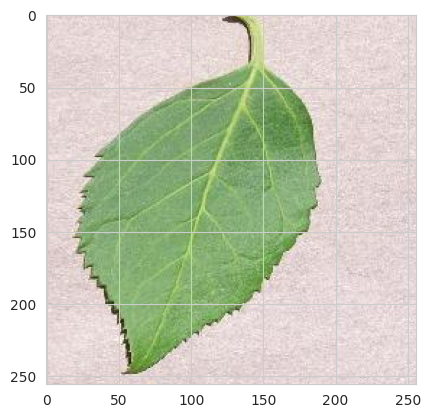

(20, 256, 256, 3)


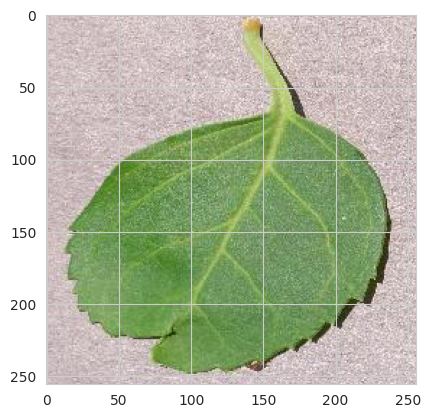

In [16]:
for _ in range(4):
    img, label = next(validation_set)
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

### Plot augmented test images

(20, 256, 256, 3)


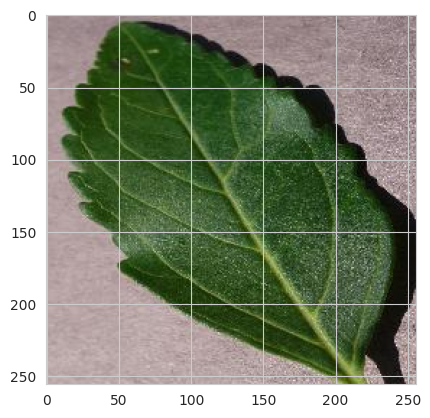

(20, 256, 256, 3)


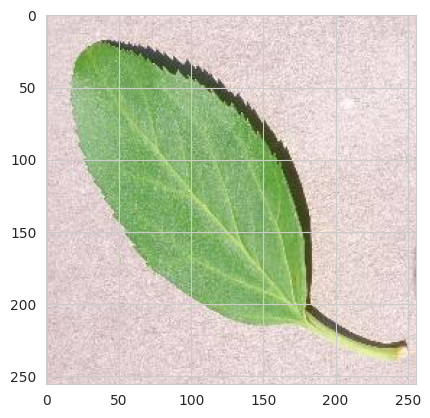

(20, 256, 256, 3)


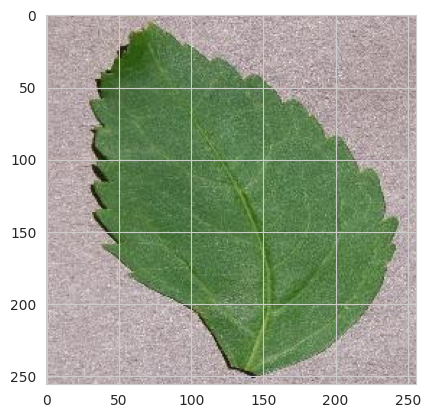

(20, 256, 256, 3)


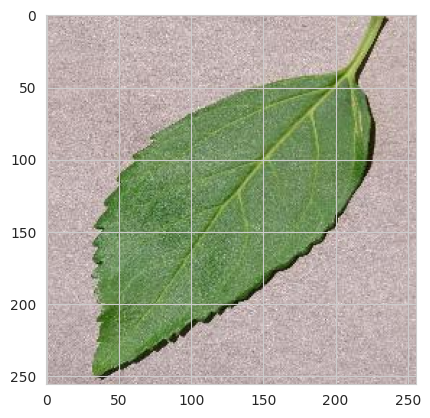

In [17]:
for _ in range(4):
    img, label = next(test_set)
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

All images were successfully augmented.

### Save class indices

We save the class indices for both labels to be used later on in the output folder.

In [18]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

## Model Creation

The model we create should learn from the dominant feature of our labelled images, in our case the diminant feature is thew whitish powder on the green leaves which is there because they are mildew infected.

### Machine Learning Model

We create a model by defining the function ```create_tf_model```.

Our model has five layers:
* convolution - seleccts the dominant pixel value from the non-dominant pixels
* max-pooling - reduces the size of the image which contains the dominant feature
* flatten - flattens matrix into a list of values (vector)
* dense - gives the output
* dropout - avoids overfitting

We set the compiler and do a binary classification with the ```softmax``` ffunction

These layers inrease the accuracy and develop a convolution neural network.

In [19]:
# code for Data Visualization and its functions were adapted and taken from Walkthrough Project 01 Malaria Detector 
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

We create the model summary to understand the numbers of our pöarameters

In [20]:
create_tf_model().summary()

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,429,506 (28.34 MB)

 Trainable params: 7,429,506 (28.34 MB)

 Non-trainable params: 0 (0.00 B)

The number of parameters are 7,662,209 (might need to be adapted since it is quite big). 

In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

Early stopping stops the model training 'activity' in a case of over- or underfitting.

We fit our model and use the ```early_stop``` variable in it.
We use 15 epochs and got a callback after the 8th epoch, therefore 8 epochs would be the best. In case we can improve our project this will be redone

In [24]:
model = create_tf_model()
model.fit(train_set,
          epochs=15,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 122s 817ms/step - accuracy: 0.6709 - loss: 0.6308 - val_accuracy: 0.9357 - val_loss: 0.1721
Epoch 2/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 1.0000 - loss: 0.0080 - val_accuracy: 0.9667 - val_loss: 0.1080
Epoch 3/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 137s 818ms/step - accuracy: 0.9671 - loss: 0.1077 - val_accuracy: 0.9857 - val_loss: 0.0885
Epoch 4/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 1.0000 - loss: 0.0547 - val_accuracy: 0.9929 - val_loss: 0.0486
Epoch 5/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 135s 807ms/step - accuracy: 0.9893 - loss: 0.0526 - val_accuracy: 0.9976 - val_loss: 0.0124
Epoch 6/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 1.0000 - loss: 3.2452e-04 - val_accuracy: 0.9976 - val_loss: 0.0129
Epoch 7/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 118s 801ms/step - accuracy: 0.9547 - loss: 0.1318 - val_accuracy: 0.9929 - val_loss: 0.0262
Epoch 8/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 1.0000 - loss: 0

We save our model to the output folder.

In [25]:
model.save('outputs/v1/mildew_detection_model.h5')

---

## Model Performance

### Create learning curves

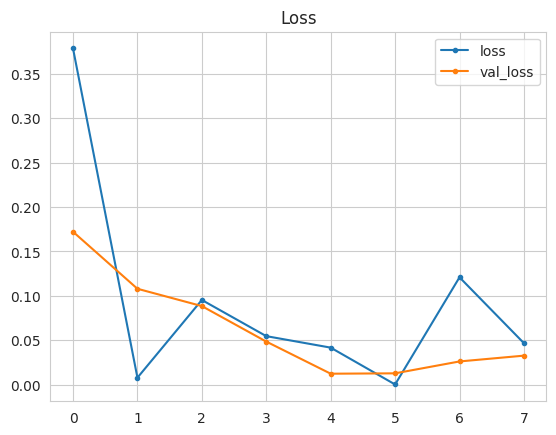

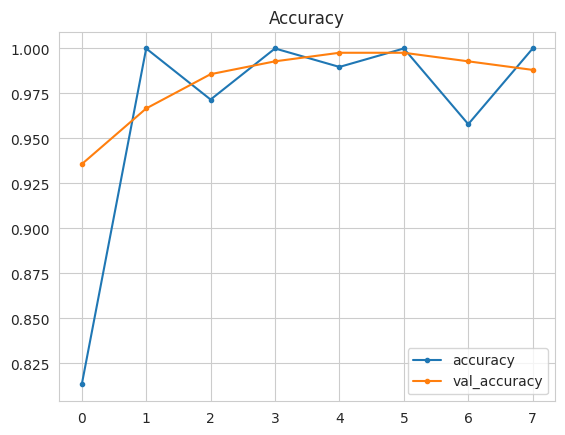

In [26]:
# code for Data Visualization and its functions were adapted and taken from Walkthrough Project 01 Malaria Detector 

losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Create Model Evaluation

We first load the model and then evaluate it on the test set.

In [27]:
from keras.models import load_model
model = load_model('outputs/v1/mildew_detection_model.h5')

In [28]:
evaluation = model.evaluate(test_set)

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.9944 - loss: 0.0136


The evaluation was succesfull, we now save it in the output folder.

In [29]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

# Section 2

Section 2 content

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
    # create here your folder
    # os.makedirs(name='')
except Exception as e:
    print(e)
